In [124]:
import pandas as pd
import numpy as np

from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

#### 0.0 **Preprocessing**

In [125]:
df_transactions_a = pd.read_excel('online_retail_II.xlsx', sheet_name="Year 2009-2010")
df_transactions_b = pd.read_excel('online_retail_II.xlsx', sheet_name="Year 2010-2011")

df_transactions = pd.concat([df_transactions_a, df_transactions_b], axis=0)
print(f"Dataframe shape: {df_transactions.shape}")

Dataframe shape: (1067371, 8)


In [126]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1067371 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 73.3+ MB


In [127]:
def preprocessing_1(df:pd.DataFrame) -> pd.DataFrame:
    """
    Function that implements all the preprocessing steps
    required as a result of our EDA (`EDA.ipynb`).

    ### Args
    - df: A raw pandas dataframe

    ### Returns
    - df: A preprocessed pandas dataframe
    """

    df_ = df.copy()

    # drop null values
    df_.dropna(inplace = True)

    # drop negative values in Price & Quantity
    df_ = df_.query("Quantity > 0 & Price > 0")

    # ensure correct data types
    df_[["Invoice", "StockCode", "Description"]] = \
        df_[["Invoice", "StockCode", "Description"]].astype('string')

    df_["Country"] = df_["Country"].astype('category')

    df_['Customer ID'] = df_['Customer ID'].astype("int").astype('category')

    # drop cancelled invoices
    df_ = df_[~df_["Invoice"].str.startswith("C")]

    # drop dummy stocks
    df_ = df_[~df_["StockCode"].str.contains("TEST")]

    df_.drop_duplicates(inplace=True)
        
    assert all(df["InvoiceDate"] > datetime(2009,1,1))
    assert all(df["InvoiceDate"] < datetime(2012,1,1))

    return df_

In [128]:
df = preprocessing_1(df_transactions)
print(f"Shape of preprocessed dataframe: {df.shape}")
print("")
print(df.info())
print("")
df.head(3)

C:\Users\USER\AppData\Local\Temp\ipykernel_2964\2611484258.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_[["Invoice", "StockCode", "Description"]] = \
C:\Users\USER\AppData\Local\Temp\ipykernel_2964\2611484258.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_["Country"] = df_["Country"].astype('category')
C:\Users\USER\AppData\Local\Temp\ipykernel_2964\2611484258.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

Shape of preprocessed dataframe: (779415, 8)

<class 'pandas.core.frame.DataFrame'>
Index: 779415 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      779415 non-null  string        
 1   StockCode    779415 non-null  string        
 2   Description  779415 non-null  string        
 3   Quantity     779415 non-null  int64         
 4   InvoiceDate  779415 non-null  datetime64[ns]
 5   Price        779415 non-null  float64       
 6   Customer ID  779415 non-null  category      
 7   Country      779415 non-null  category      
dtypes: category(2), datetime64[ns](1), float64(1), int64(1), string(3)
memory usage: 44.0 MB
None



,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom


#### 1.0 **RFM Analysis**

We'll now proceed to feature engineer the following metrics:
- **Recency**: Calculate the number of days since the last purchase for each customer.
- **Frequency**: Compute how often each customer makes a purchase.
- **Monetary**: Determine the total amount of money each customer has spent.

This will enable us to segment customers into quantiles for each RFM metric (e.g., quartiles).

In [129]:
# Feature engineer the TotalPrice column the amount purchased per invoice.d
# This will help us calculate `Monetary`.
df["TotalPrice"] = df["Quantity"] * df["Price"]

In [130]:
# Convert a timestamp col to date col
df['InvoiceDate_notime'] = pd.to_datetime(df['InvoiceDate']).dt.date

In [131]:
max_date = max(df["InvoiceDate_notime"])
max_date

datetime.date(2011, 12, 9)

In [132]:
rfm = df.groupby("Customer ID").agg(monetary = ("TotalPrice", "sum"),
                                    frequency = ("Invoice", lambda x: x.nunique()),
                                    recency = ("InvoiceDate_notime", lambda y: max_date - y.max()))

# change `recency` column from datetime.date to integer
# and plus 1 since we're doing it after the fact.
rfm["recency"] = rfm["recency"].dt.days.astype("int") + 1

print(rfm.info())
print("")
rfm.head(3)

C:\Users\USER\AppData\Local\Temp\ipykernel_2964\2832939927.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rfm = df.groupby("Customer ID").agg(monetary = ("TotalPrice", "sum"),


<class 'pandas.core.frame.DataFrame'>
CategoricalIndex: 5878 entries, 12346 to 18287
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   monetary   5878 non-null   float64
 1   frequency  5878 non-null   int64  
 2   recency    5878 non-null   int32  
dtypes: float64(1), int32(1), int64(1)
memory usage: 246.3 KB
None



,monetary,frequency,recency
Customer ID,,,
12346,77352.96,3,326
12347,4921.53,8,3
12348,2019.40,5,76


In [133]:
rfm.describe()

,monetary,frequency,recency
count,5878.00,5878.00,5878.00
mean,2955.87,6.29,201.87
std,14440.67,13.01,209.35
min,2.95,1.00,1.00
25%,342.28,1.00,26.00
50%,867.74,3.00,96.00
75%,2248.30,7.00,380.00
max,580987.04,398.00,739.00


We can now segment customers into quantiles for each RFM metric (e.g., quartiles). However, we note that due to outliers, our rfm dataframe isn't able to be segmented into quartiles for the `frequency` column.

In [134]:
# Create quartiles for each RFM metric and add quartile labels to the DataFrame
rfm['Recency_Quartile'] = pd.qcut(rfm['recency'], 
                                  q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
rfm['Frequency_Quartile'] = pd.qcut(rfm['frequency'], labels=['Q1', 'Q2', 'Q3'], 
                                    q=3) # there's only 3 segments as per below
rfm['MonetaryValue_Quartile'] = pd.qcut(rfm['monetary'], 
                                        q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

rfm.head(3)

,monetary,frequency,recency,Recency_Quartile,Frequency_Quartile,MonetaryValue_Quartile
Customer ID,,,,,,
12346,77352.96,3,326,Q3,Q2,Q4
12347,4921.53,8,3,Q1,Q3,Q4
12348,2019.40,5,76,Q2,Q2,Q3


In [135]:
rfm['Frequency_Quartile'].unique()

['Q2', 'Q3', 'Q1']
Categories (3, object): ['Q1' < 'Q2' < 'Q3']

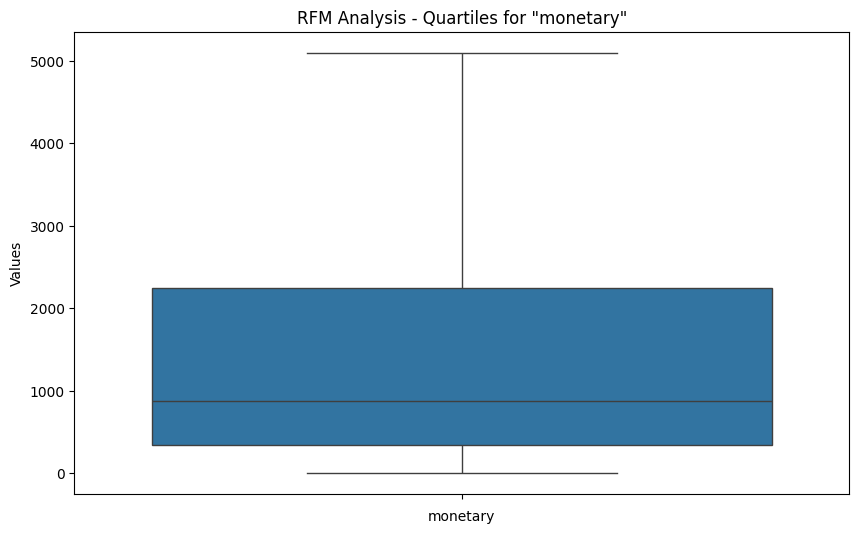

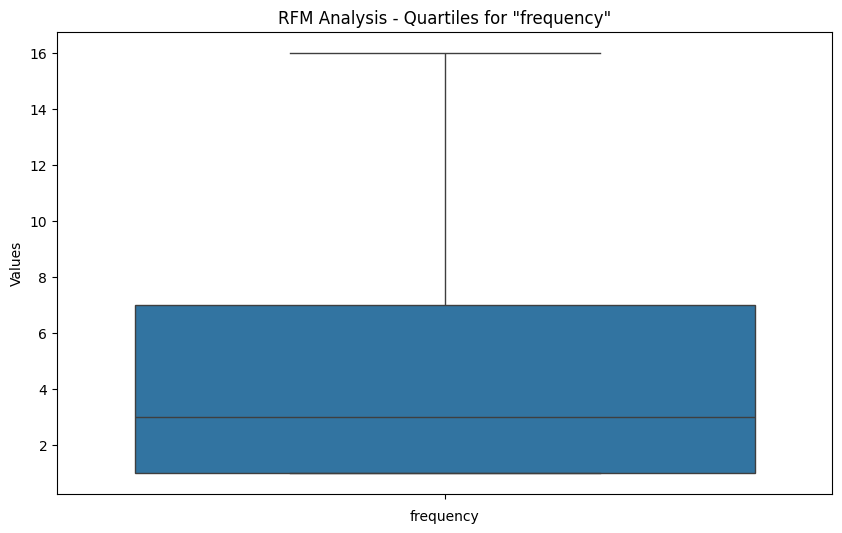

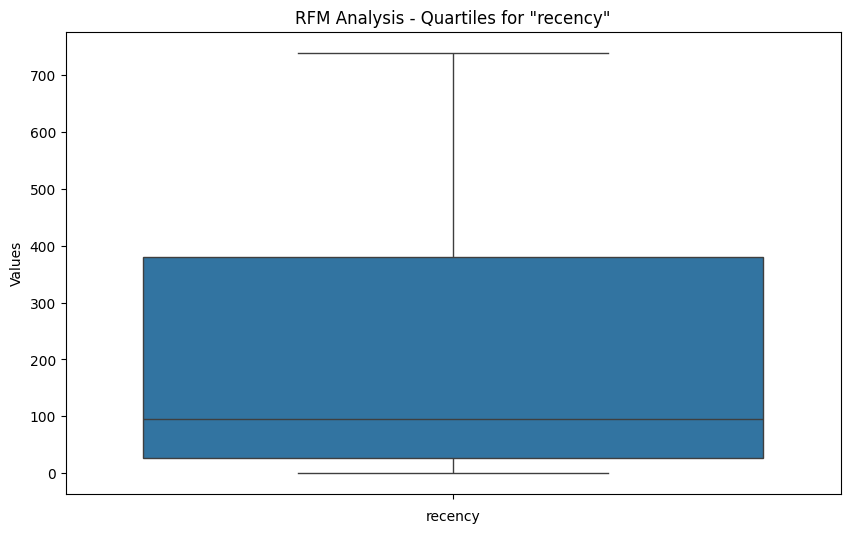

In [136]:
# Create a boxplot showing quartiles without outliers
for i in rfm.columns[:3]:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=rfm[i], showfliers=False)
    plt.title(f'RFM Analysis - Quartiles for "{i}"')
    plt.xlabel(i)
    plt.ylabel('Values')
    plt.show()

#### 2.0 **Segmentation**

We'll now use the RFM scores to segment customers into distinct clusters using the K-Means algorithm.

We note that K-Means can be sensitive to outliers, as it tries to minimize the sum of squared distances. Hence, outliers can disproportionately influence the location of cluster centroids. This is especially the case as our data is skewed to the right. Hence, before we do any clustering, we need to unskew the variables (with a log transformation) and standardize them afterwards.

In [138]:
# Apply a logarithmic transformation to rfm
rfm_log = np.log(rfm[['recency', 'frequency', 'monetary']])

After applying the logarithmic transformation, we further standardize the data to ensure that all columns have comparable scales. We use StandardScaler from Scikit-Learn for this purpose.

In [139]:
scaler = StandardScaler()

rfm_scaled = pd.DataFrame(scaler.fit_transform(rfm_log), 
                                columns=['recency', 'frequency', 'monetary'])

Now we need to find the optimum number of clusters, to do so we will compute the the Silhouette score (higher is best) & the Elbow method on the inertia metric (best number of clusters at the elbow/kink).

In [140]:
inertias = []
silhouettes = []
n_clusters = np.arange(2, 10, 1)

for n in n_clusters:
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(rfm_scaled)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(rfm_scaled, kmeans.predict(rfm_scaled)))

c:\Users\USER\anaconda3\envs\publicis_assessment_ds\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


c:\Users\USER\anaconda3\envs\publicis_assessment_ds\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\USER\anaconda3\envs\publicis_assessment_ds\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\USER\anaconda3\envs\publicis_assessment_ds\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\USER\anaconda3\envs\publicis_assessment_ds\Lib\site-packages\sklearn\cluster\_kmeans.

The plot suggest that the best number of clusters is 4, Kmeans will compute and assign the clusters for each customer.

Text(0, 0.5, 'Inertia score')

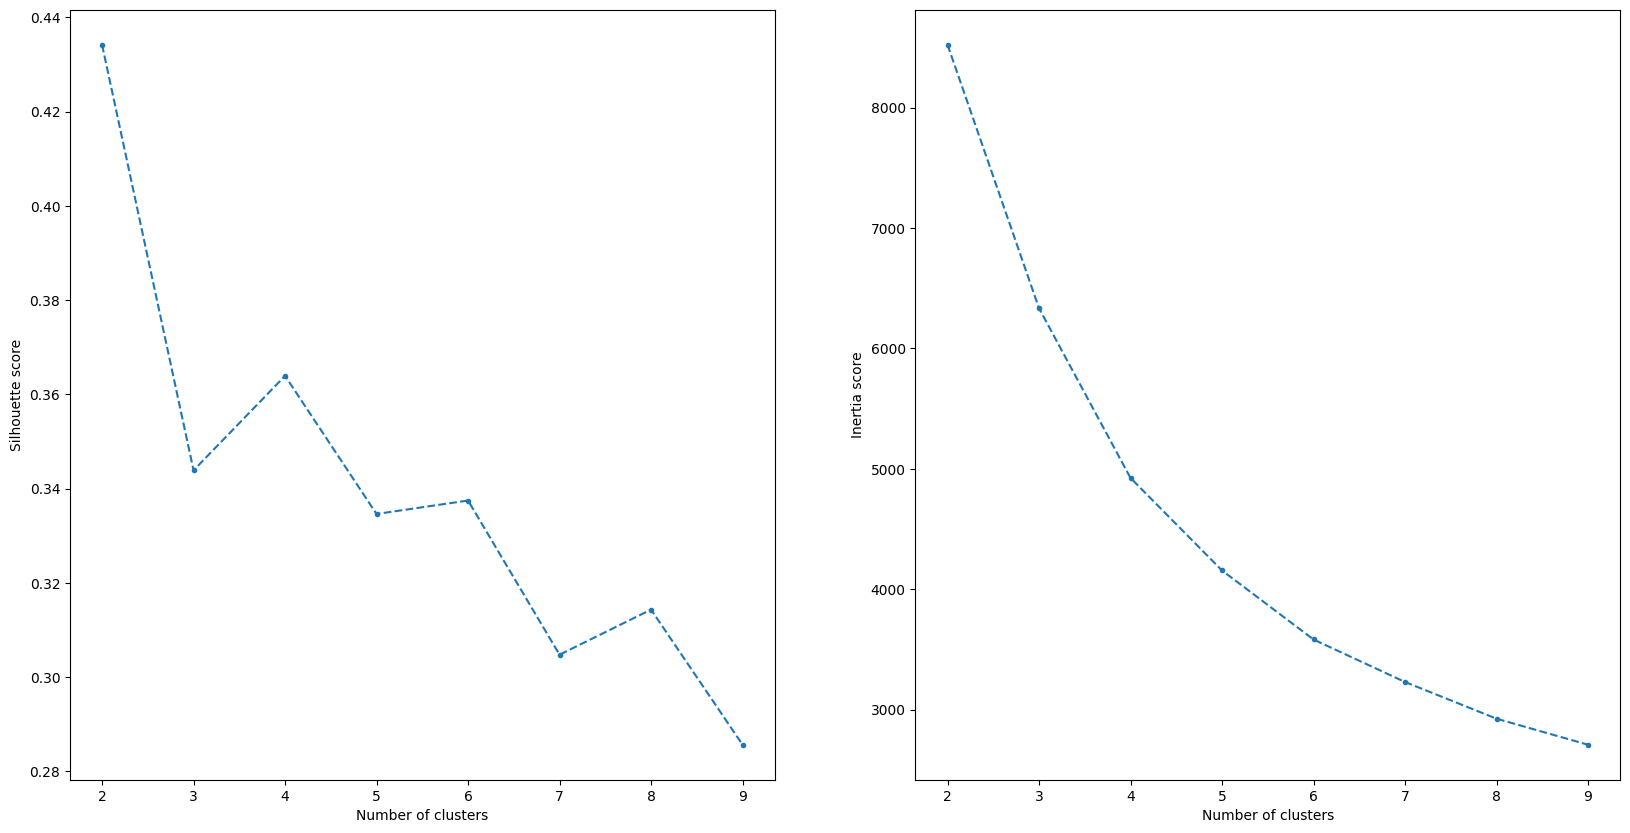

In [141]:
f, ax = plt.subplots(1, 2, figsize=(20, 10))
for a in ax.flatten():
    a.set_xlabel("Number of clusters")

ax[0].plot(n_clusters, silhouettes, ".--")
ax[0].set_ylabel("Silhouette score")

ax[1].plot(n_clusters, inertias, ".--")
ax[1].set_ylabel("Inertia score")

In [142]:
nclusters=4
kmeans = KMeans(n_clusters=nclusters, random_state=13)
kmeans.fit(rfm_scaled)

rfm["cluster"] = kmeans.predict(rfm_scaled)

c:\Users\USER\anaconda3\envs\publicis_assessment_ds\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


#### 3.0 **Interpretation of each cluster & marketing campaign recommendations**

We can now check the distribution and components of each cluster:

- `Cluster 1` seems to be best cluster although it is the 2nd smallest. This group spends more money and made the most transactions, and in average had their last transactions 27 days ago. These are the regular customers so loyalty programmes that encourage long-term patronage is a suitable campaign for them.

- `Cluster 0` is the next best cluster, because they make the 2nd most amount of money. However the customers in that group haven't come for a while. Hence, more targeted marketing efforts focused on building brand awareness and engagement is the recommendation for the long term. Over time, promotions e.g., free shipping or discounts can eventually be made to induce loyalty and patronage.

- `Cluster 2` can be characterised as those that spend less money, but order relatively frequently (as their last transactions a month ago). Promotions and discounts are likely to work well for this group to encourage them to spend more.

- Customers in `Cluster 3` have likely churned as they haven't spend much and haven't stopped by in a long time. This is worrisome as they make up the largest cluster.

In [143]:
rfm["cluster"].value_counts()

cluster
3    1948
0    1534
1    1228
2    1168
Name: count, dtype: int64

In [145]:
pd.set_option('display.float_format', '{:.2f}'.format)

rfm[["recency", "monetary", "frequency", "cluster"]].groupby("cluster").mean()

,recency,monetary,frequency
cluster,,,
0,234.98,1915.75,4.97
1,27.37,10464.66,18.89
2,28.09,837.08,3.07
3,389.99,311.87,1.31


In [151]:
pd.DataFrame(rfm[["Recency_Quartile", "cluster"]].groupby("cluster").value_counts(normalize=True))

proportion
cluster Recency_Quartile            
0       Q3                      0.52
        Q2                      0.26
        Q4                      0.23
        Q1                      0.00
1       Q1                      0.67
        Q2                      0.30
        Q3                      0.03
        Q4                      0.00
2       Q1                      0.57
        Q2                      0.43
        Q3                      0.00
        Q4                      0.00
3       Q4                      0.57
        Q3                      0.32
        Q2                      0.10
        Q1                      0.00

In [147]:
pd.DataFrame(rfm[["Frequency_Quartile", "cluster"]].groupby("cluster").value_counts(normalize=True))

proportion
cluster Frequency_Quartile            
0       Q2                        0.55
        Q3                        0.33
        Q1                        0.12
1       Q3                        0.97
        Q2                        0.03
        Q1                        0.00
2       Q2                        0.48
        Q1                        0.43
        Q3                        0.09
3       Q1                        0.96
        Q2                        0.04
        Q3                        0.00

In [148]:
pd.DataFrame(rfm[["MonetaryValue_Quartile", "cluster"]].groupby("cluster").value_counts(normalize=True))

proportion
cluster MonetaryValue_Quartile            
0       Q3                            0.54
        Q4                            0.23
        Q2                            0.22
        Q1                            0.01
1       Q4                            0.89
        Q3                            0.11
        Q2                            0.00
        Q1                            0.00
2       Q2                            0.44
        Q3                            0.38
        Q1                            0.16
        Q4                            0.02
3       Q1                            0.66
        Q2                            0.32
        Q3                            0.03
        Q4                            0.00

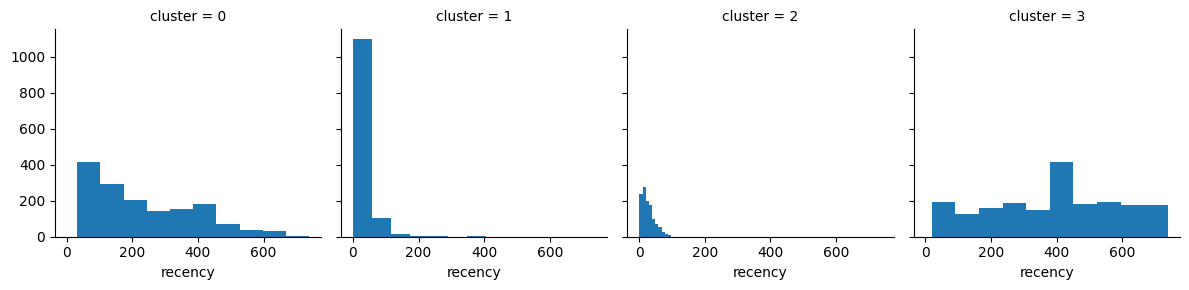

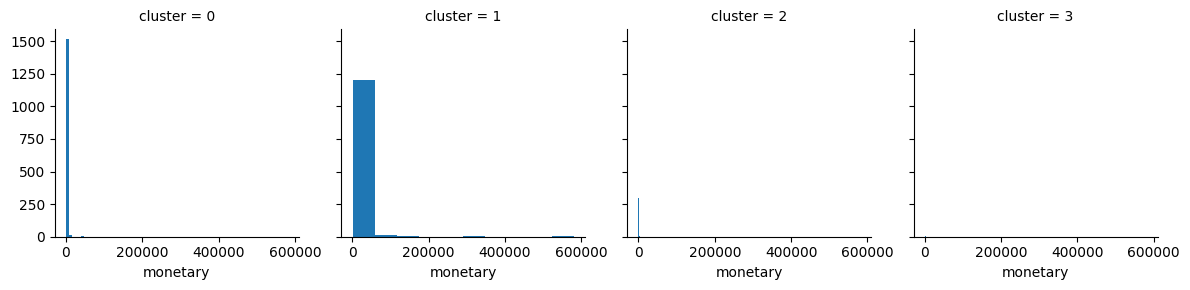

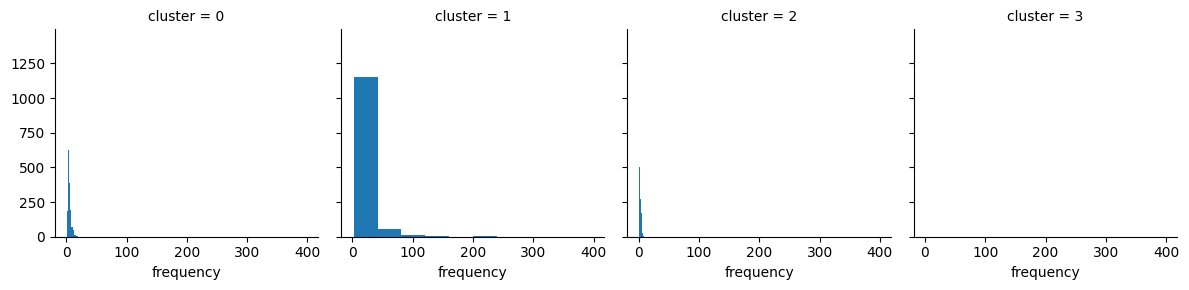

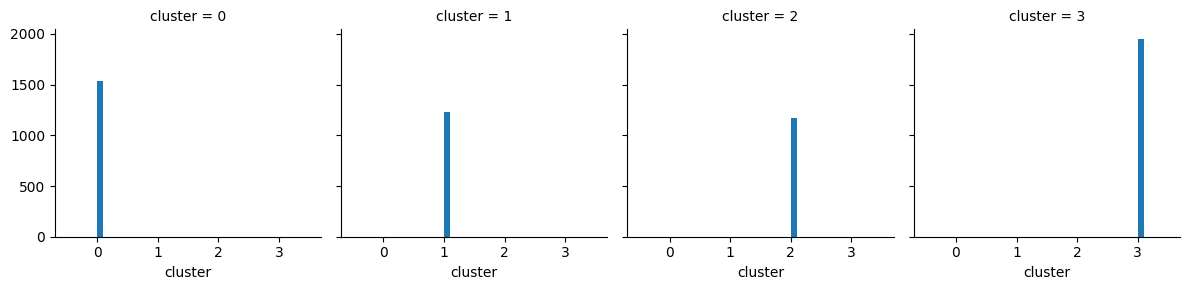

In [149]:
for c in rfm[["recency", "monetary", "frequency", "cluster"]]:
    grid= sns.FacetGrid(rfm[["recency", "monetary", "frequency", "cluster"]], col='cluster')
    grid.map(plt.hist, c)